In [82]:
import pandas as pd
import os
from itables import show
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import gc

In [83]:
#finding out how many cpu cores you have
!wmic cpu get NumberOfCores,NumberOfLogicalProcessors

#divide the work between the existing cores - 1
os.environ['OMP_NUM_THREADS']='7'

NumberOfCores  NumberOfLogicalProcessors  

4              8                          





# General preprocessing

In [102]:
traffic = pd.read_csv('traffic_2020-2022_orientation.csv')
weather = pd.read_csv('weather_data_hourly.csv')
emissions = pd.read_csv('emission_huegelstr_hourly.csv')

In [103]:
pred_data = traffic.merge(weather, how='left', on= 'timestamp').merge(emissions[['PM10','PM2,5', 'NO2','timestamp']], how='left', on= 'timestamp')
show(pred_data)

df = pred_data.copy()

In [104]:
df.index = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df[:26]

,timestamp,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",NO2
timestamp,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,2020-06-01 00:00:00,153.0,256.0,224.0,275.0,28.0,339.2,185.0,1346.31,1021.0,72.75,13.10,0.60,96.0,9.25,4.75,9.70
2020-06-01 01:00:00,2020-06-01 01:00:00,87.0,174.4,142.0,54.0,15.0,222.4,116.0,406.90,1022.0,81.75,10.75,0.40,112.0,5.65,3.25,10.05
2020-06-01 02:00:00,2020-06-01 02:00:00,56.0,96.8,83.0,25.0,16.0,119.0,68.0,243.41,1022.0,93.05,9.35,0.45,76.5,5.05,3.05,11.40
2020-06-01 03:00:00,2020-06-01 03:00:00,39.0,63.6,43.0,15.0,3.0,89.4,42.0,272.47,1022.0,96.55,8.40,0.55,71.5,6.25,3.35,11.10
2020-06-01 04:00:00,2020-06-01 04:00:00,12.0,82.5,50.0,11.0,4.0,106.4,33.0,413.96,1022.0,98.55,7.80,0.40,111.5,6.00,3.35,9.65
2020-06-01 05:00:00,2020-06-01 05:00:00,90.0,162.5,100.0,137.0,8.0,201.4,44.0,1260.45,1022.0,97.25,8.15,0.50,110.0,6.50,3.85,13.00
2020-06-01 06:00:00,2020-06-01 06:00:00,94.0,186.7,98.0,204.0,16.0,161.6,90.0,1530.86,1022.0,86.20,10.90,1.05,52.0,6.10,3.65,8.80
2020-06-01 07:00:00,2020-06-01 07:00:00,108.0,168.7,127.0,217.0,17.0,188.8,89.0,1539.37,1022.0,71.90,13.45,1.40,41.5,6.30,3.25,6.30
2020-06-01 08:00:00,2020-06-01 08:00:00,157.0,252.8,208.0,279.0,48.0,283.2,168.0,1491.31,1022.0,62.55,15.80,1.60,48.5,8.75,3.60,5.45


# Univariate Time Series Forecasting with LSTM for one time step

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [23]:
no2 = pred_data.copy()
no2 = no2.iloc[:,16]
no2.fillna(no2.mean(), inplace = True)
no2

0         9.70
1        10.05
2        11.40
3        11.10
4         9.65
         ...  
17536    15.80
17537    25.30
17538    32.30
17539    26.60
17540    14.05
Name: NO2, Length: 17541, dtype: float64

## Create Tensors

In [24]:
# define X and y from dataset
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [25]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(no2, WINDOW_SIZE)
X1.shape, y1.shape

((17536, 5, 1), (17536,))

In [26]:
#create train, val and test data
X_train1, y_train1 = X1[:15000], y1[:15000]
X_val1, y_val1 = X1[15000:16500], y1[15000:16500]
X_test1, y_test1 = X1[16500:], y1[16500:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((15000, 5, 1), (15000,), (1500, 5, 1), (1500,), (1036, 5, 1), (1036,))

## Create model

In [27]:
#create model
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [28]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

## Train model

In [29]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=5, callbacks=[cp1])

Epoch 1/5


459/469 [============================>.] - ETA: 0s - loss: 989.1481 - root_mean_squared_error: 31.4507

469/469 [==============================] - 19s 32ms/step - loss: 989.6215 - root_mean_squared_error: 31.4583 - val_loss: 1053.6268 - val_root_mean_squared_error: 32.4596
Epoch 2/5
458/469 [============================>.] - ETA: 0s - loss: 981.9946 - root_mean_squared_error: 31.3368

469/469 [==============================] - 16s 33ms/step - loss: 981.4401 - root_mean_squared_error: 31.3279 - val_loss: 1051.0634 - val_root_mean_squared_error: 32.4201
Epoch 3/5
469/469 [==============================] - ETA: 0s - loss: 978.8792 - root_mean_squared_error: 31.2870

469/469 [==============================] - 15s 31ms/step - loss: 978.8792 - root_mean_squared_error: 31.2870 - val_loss: 1048.5187 - val_root_mean_squared_error: 32.3808
Epoch 4/5
463/469 [============================>.] - ETA: 0s - loss: 976.7904 - root_mean_squared_error: 31.2536

469/469 [==============================] - 14s 31ms/step - loss: 976.3246 - root_mean_squared_error: 31.2462 - val_loss: 1045.9814 - val_root_mean_squared_error: 32.3416
Epoch 5/5
468/469 [============================>.] - ETA: 0s - loss: 973.5836 - root_mean_squared_error: 31.2023

469/469 [==============================] - 14s 31ms/step - loss: 973.7758 - root_mean_squared_error: 31.2054 - val_loss: 1043.4510 - val_root_mean_squared_error: 32.3025


In [30]:
model1 = load_model('model1/')

## Predict NO2 and evaluate model

In [31]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

469/469 [==============================] - 2s 2ms/step


,Train Predictions,Actuals
0,0.232812,13.00
1,0.232812,8.80
2,0.232812,6.30
3,0.232812,5.45
4,0.232812,5.65
...,...,...
14995,0.232812,6.80
14996,0.232812,6.00
14997,0.232812,6.70
14998,0.232812,9.70


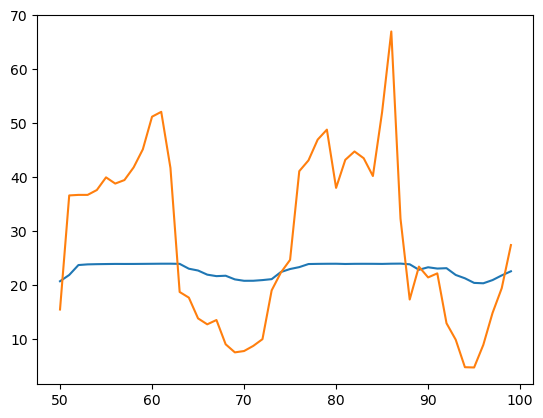

In [191]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [192]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

 1/25 [>.............................] - ETA: 0s

25/25 [==============================] - 0s 3ms/step


,Val Predictions,Actuals
0,23.868557,31.70
1,23.771009,85.10
2,23.909842,46.80
3,23.881636,23.25
4,23.394419,24.85
...,...,...
795,23.710463,26.35
796,23.562376,25.45
797,23.470255,12.15
798,21.818258,16.50


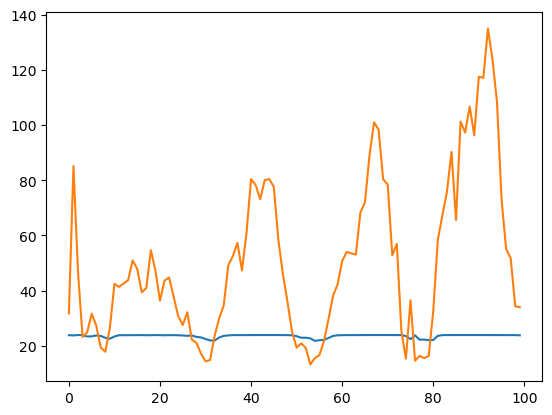

In [193]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [194]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

1415/1415 [==============================] - 4s 3ms/step


,Test Predictions,Actuals
0,22.314184,25.50
1,23.234240,44.45
2,23.844664,56.25
3,23.890198,61.60
4,23.899696,82.70
...,...,...
45265,21.006189,11.50
45266,21.307547,17.35
45267,22.173601,20.55
45268,22.678564,19.00


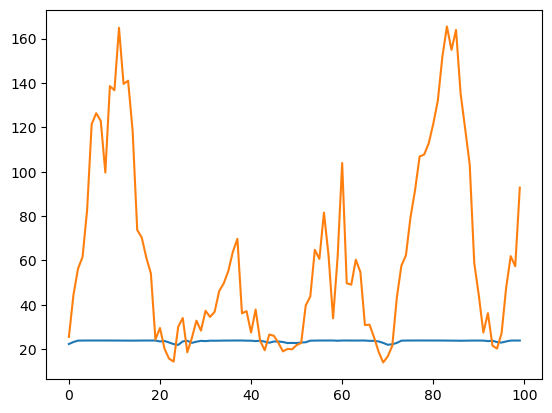

In [195]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

## Convolutional Neural Network

In [196]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 8)                 2056      
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [197]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [198]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
114/125 [==========================>...] - ETA: 0s - loss: 3057.3616 - root_mean_squared_error: 55.2934

125/125 [==============================] - 3s 17ms/step - loss: 3038.4912 - root_mean_squared_error: 55.1225 - val_loss: 3165.1382 - val_root_mean_squared_error: 56.2596
Epoch 2/10
117/125 [===========================>..] - ETA: 0s - loss: 2652.0776 - root_mean_squared_error: 51.4983

125/125 [==============================] - 3s 21ms/step - loss: 2635.0562 - root_mean_squared_error: 51.3328 - val_loss: 2746.5215 - val_root_mean_squared_error: 52.4073
Epoch 3/10
109/125 [=========================>....] - ETA: 0s - loss: 2194.4509 - root_mean_squared_error: 46.8450

125/125 [==============================] - 2s 16ms/step - loss: 2175.9509 - root_mean_squared_error: 46.6471 - val_loss: 2149.4832 - val_root_mean_squared_error: 46.3625
Epoch 4/10
115/125 [==========================>...] - ETA: 0s - loss: 1601.0270 - root_mean_squared_error: 40.0128

125/125 [==============================] - 2s 14ms/step - loss: 1583.0426 - root_mean_squared_error: 39.7875 - val_loss: 1472.9048 - val_root_mean_squared_error: 38.3784
Epoch 5/10
121/125 [============================>.] - ETA: 0s - loss: 1011.7217 - root_mean_squared_error: 31.8076

125/125 [==============================] - 3s 27ms/step - loss: 1010.8896 - root_mean_squared_error: 31.7945 - val_loss: 938.2759 - val_root_mean_squared_error: 30.6313
Epoch 6/10
113/125 [==========================>...] - ETA: 0s - loss: 658.0784 - root_mean_squared_error: 25.6530

125/125 [==============================] - 2s 18ms/step - loss: 652.8606 - root_mean_squared_error: 25.5511 - val_loss: 698.8687 - val_root_mean_squared_error: 26.4361
Epoch 7/10
125/125 [==============================] - ETA: 0s - loss: 524.7438 - root_mean_squared_error: 22.9073

125/125 [==============================] - 2s 18ms/step - loss: 524.7438 - root_mean_squared_error: 22.9073 - val_loss: 640.5900 - val_root_mean_squared_error: 25.3099
Epoch 8/10
113/125 [==========================>...] - ETA: 0s - loss: 487.1832 - root_mean_squared_error: 22.0722

125/125 [==============================] - 2s 17ms/step - loss: 495.3465 - root_mean_squared_error: 22.2564 - val_loss: 627.0126 - val_root_mean_squared_error: 25.0402
Epoch 9/10
121/125 [============================>.] - ETA: 0s - loss: 485.3132 - root_mean_squared_error: 22.0298

125/125 [==============================] - 3s 25ms/step - loss: 485.6902 - root_mean_squared_error: 22.0384 - val_loss: 616.8571 - val_root_mean_squared_error: 24.8366
Epoch 10/10
123/125 [============================>.] - ETA: 0s - loss: 480.5810 - root_mean_squared_error: 21.9222

125/125 [==============================] - 3s 21ms/step - loss: 477.2912 - root_mean_squared_error: 21.8470 - val_loss: 606.0822 - val_root_mean_squared_error: 24.6187


## GRU (Gated Recurrent Unit)

In [199]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [200]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [201]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
120/125 [===========================>..] - ETA: 0s - loss: 3151.0195 - root_mean_squared_error: 56.1339

125/125 [==============================] - 19s 127ms/step - loss: 3142.4509 - root_mean_squared_error: 56.0576 - val_loss: 3486.8010 - val_root_mean_squared_error: 59.0491
Epoch 2/10
123/125 [============================>.] - ETA: 0s - loss: 3043.4119 - root_mean_squared_error: 55.1671

125/125 [==============================] - 13s 109ms/step - loss: 3037.2146 - root_mean_squared_error: 55.1109 - val_loss: 3343.7737 - val_root_mean_squared_error: 57.8254
Epoch 3/10
114/125 [==========================>...] - ETA: 0s - loss: 2888.9329 - root_mean_squared_error: 53.7488

125/125 [==============================] - 13s 101ms/step - loss: 2873.4370 - root_mean_squared_error: 53.6045 - val_loss: 3170.0459 - val_root_mean_squared_error: 56.3032
Epoch 4/10
116/125 [==========================>...] - ETA: 0s - loss: 2698.9668 - root_mean_squared_error: 51.9516

125/125 [==============================] - 15s 121ms/step - loss: 2714.0010 - root_mean_squared_error: 52.0961 - val_loss: 3012.4443 - val_root_mean_squared_error: 54.8857
Epoch 5/10
123/125 [============================>.] - ETA: 0s - loss: 2558.4678 - root_mean_squared_error: 50.5813

125/125 [==============================] - 17s 134ms/step - loss: 2563.7192 - root_mean_squared_error: 50.6332 - val_loss: 2862.0950 - val_root_mean_squared_error: 53.4986
Epoch 6/10
124/125 [============================>.] - ETA: 0s - loss: 2432.2261 - root_mean_squared_error: 49.3176

125/125 [==============================] - 15s 123ms/step - loss: 2431.9407 - root_mean_squared_error: 49.3147 - val_loss: 2731.5154 - val_root_mean_squared_error: 52.2639
Epoch 7/10
118/125 [===========================>..] - ETA: 0s - loss: 2320.3469 - root_mean_squared_error: 48.1700

125/125 [==============================] - 17s 135ms/step - loss: 2313.1785 - root_mean_squared_error: 48.0955 - val_loss: 2610.1116 - val_root_mean_squared_error: 51.0893
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 2202.0059 - root_mean_squared_error: 46.9255

125/125 [==============================] - 16s 125ms/step - loss: 2202.0059 - root_mean_squared_error: 46.9255 - val_loss: 2495.6746 - val_root_mean_squared_error: 49.9567
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 2086.2783 - root_mean_squared_error: 45.6758

125/125 [==============================] - 16s 129ms/step - loss: 2092.8127 - root_mean_squared_error: 45.7473 - val_loss: 2378.0422 - val_root_mean_squared_error: 48.7652
Epoch 10/10
123/125 [============================>.] - ETA: 0s - loss: 1982.7573 - root_mean_squared_error: 44.5282

125/125 [==============================] - 14s 112ms/step - loss: 1979.6104 - root_mean_squared_error: 44.4928 - val_loss: 2260.3174 - val_root_mean_squared_error: 47.5428


# Multivariate Time Series Forecasting (LSTM) for one time step

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping


from sklearn.metrics import mean_squared_error as mse

## Additional preprocessing for multivariate forecasting

In [105]:
#copy df
multi_df = pred_data.copy()
#conver timestamp to datetime
multi_df.index = pd.to_datetime(multi_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
##create column 'Seconds' for further feature engineering
multi_df['Seconds'] = multi_df.index.map(pd.Timestamp.timestamp)


In [106]:
#create columns that represent time relations
day = 60*60*24
year = 365.2425*day

multi_df['Day sin'] = np.sin(multi_df['Seconds'] * (2* np.pi / day))
multi_df['Day cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / day))
multi_df['Year sin'] = np.sin(multi_df['Seconds'] * (2 * np.pi / year))
multi_df['Year cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / year))
multi_df['weekday'] = multi_df.index.day_of_week
multi_df.head()


,timestamp,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],...,Windrichtung[Grad],PM10,"PM2,5",NO2,Seconds,Day sin,Day cos,Year sin,Year cos,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,2020-06-01 00:00:00,153.0,256.0,224.0,275.0,28.0,339.2,185.0,1346.31,1021.0,...,96.0,9.25,4.75,9.70,1.590970e+09,-9.128657e-12,1.000000,0.504602,-0.863352,0
2020-06-01 01:00:00,2020-06-01 01:00:00,87.0,174.4,142.0,54.0,15.0,222.4,116.0,406.90,1022.0,...,112.0,5.65,3.25,10.05,1.590973e+09,2.588190e-01,0.965926,0.503983,-0.863714,0
2020-06-01 02:00:00,2020-06-01 02:00:00,56.0,96.8,83.0,25.0,16.0,119.0,68.0,243.41,1022.0,...,76.5,5.05,3.05,11.40,1.590977e+09,5.000000e-01,0.866025,0.503364,-0.864075,0
2020-06-01 03:00:00,2020-06-01 03:00:00,39.0,63.6,43.0,15.0,3.0,89.4,42.0,272.47,1022.0,...,71.5,6.25,3.35,11.10,1.590980e+09,7.071068e-01,0.707107,0.502744,-0.864435,0
2020-06-01 04:00:00,2020-06-01 04:00:00,12.0,82.5,50.0,11.0,4.0,106.4,33.0,413.96,1022.0,...,111.5,6.00,3.35,9.65,1.590984e+09,8.660254e-01,0.500000,0.502125,-0.864795,0


In [107]:
#move target to be first column
column_to_move = multi_df.pop('NO2')
multi_df.insert(0, 'NO2', column_to_move)
multi_df.head()

,NO2,timestamp,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,...,Windgeschwindigkeit[m/s],Windrichtung[Grad],PM10,"PM2,5",Seconds,Day sin,Day cos,Year sin,Year cos,weekday
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,9.70,2020-06-01 00:00:00,153.0,256.0,224.0,275.0,28.0,339.2,185.0,1346.31,...,0.60,96.0,9.25,4.75,1.590970e+09,-9.128657e-12,1.000000,0.504602,-0.863352,0
2020-06-01 01:00:00,10.05,2020-06-01 01:00:00,87.0,174.4,142.0,54.0,15.0,222.4,116.0,406.90,...,0.40,112.0,5.65,3.25,1.590973e+09,2.588190e-01,0.965926,0.503983,-0.863714,0
2020-06-01 02:00:00,11.40,2020-06-01 02:00:00,56.0,96.8,83.0,25.0,16.0,119.0,68.0,243.41,...,0.45,76.5,5.05,3.05,1.590977e+09,5.000000e-01,0.866025,0.503364,-0.864075,0
2020-06-01 03:00:00,11.10,2020-06-01 03:00:00,39.0,63.6,43.0,15.0,3.0,89.4,42.0,272.47,...,0.55,71.5,6.25,3.35,1.590980e+09,7.071068e-01,0.707107,0.502744,-0.864435,0
2020-06-01 04:00:00,9.65,2020-06-01 04:00:00,12.0,82.5,50.0,11.0,4.0,106.4,33.0,413.96,...,0.40,111.5,6.00,3.35,1.590984e+09,8.660254e-01,0.500000,0.502125,-0.864795,0


In [108]:
#drop unwanted columns
multi_df = multi_df.drop(columns = ['timestamp', 'Seconds'])

In [109]:
#replace Nans with mean
multi_df = multi_df.fillna(multi_df.mean())

## One target - one time step

### Standardize with MinMaxScaler

In [110]:
multi_df_sc = multi_df.copy()

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = multi_df_sc.drop(columns=["NO2"])

y = multi_df_sc[[ "NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).flatten()

# Create a new DataFrame with the scaled features and target variable
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns, index=multi_df_sc.index)
y_scaled_df  = pd.DataFrame(data=y_scaled, columns=y.columns, index=multi_df_sc.index)
#df_scaled = y_scaled_df.merge(X_scaled_df, left_index=True, right_index=True)
#df_scaled
X_scaled_df.shape, y_scaled.shape

((17541, 20), (17541,))

### Create tensors

In [47]:
#create X and Y for predicting ONE time step
def df_to_X_y2(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = y_scaled[(i +window_size )]
    y.append(label)
  return np.array(X), np.array(y)

In [48]:
X2, y2 = df_to_X_y2(X_scaled_df)
X2.shape, y2.shape

((17531, 10, 20), (17531,))

In [49]:
#split data
X2_train, y2_train = X2[:10000], y2[:10000]
X2_val, y2_val = X2[10000:13500], y2[10000:13500]
X2_test, y2_test = X2[13500:], y2[13500:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape


((10000, 10, 20), (10000,), (3500, 10, 20), (3500,), (4031, 10, 20), (4031,))

### Create model & predict

In [50]:
# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp4 = ModelCheckpoint('model8/', save_best_only=True)

# Create the model
model4 = Sequential()

# Input layer
model4.add(InputLayer((10,20)))

model4.add(LSTM(512))
model4.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model4.add(Dense(164, activation='linear'))#, kernel_regularizer=l1(0.001)))
model4.add(Dense(24, activation='linear'))#, kernel_regularizer=l1(0.001)))

model4.add(Dense(1, activation='linear'))

#model4.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])
model4.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])

# Display model summary
model4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1091584   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 164)               84132     
                                                                 
 dense_1 (Dense)             (None, 24)                3960      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,179,701
Trainable params: 1,179,701
Non-trainable params: 0
_________________________________________________________________


In [51]:
#fit model
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=3, callbacks=[cp4])

Epoch 1/3
313/313 [==============================] - ETA: 0s - loss: 0.0686 - mean_squared_error: 0.0161

313/313 [==============================] - 115s 332ms/step - loss: 0.0686 - mean_squared_error: 0.0161 - val_loss: 0.0554 - val_mean_squared_error: 0.0058
Epoch 2/3
313/313 [==============================] - ETA: 0s - loss: 0.0525 - mean_squared_error: 0.0055

313/313 [==============================] - 86s 275ms/step - loss: 0.0525 - mean_squared_error: 0.0055 - val_loss: 0.0460 - val_mean_squared_error: 0.0040
Epoch 3/3
313/313 [==============================] - 47s 148ms/step - loss: 0.0500 - mean_squared_error: 0.0050 - val_loss: 0.0649 - val_mean_squared_error: 0.0070


In [52]:
# function to predict and plot predictions for 1 target / one time step
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end], label = 'Predictions')
  plt.plot(df['Actuals'][start:end], label = 'Actuals')
  plt.legend()
  return df, mse(y, predictions)

126/126 [==============================] - 8s 51ms/step


(      Predictions   Actuals
 0        0.120260  0.145349
 1        0.106354  0.134690
 2        0.085944  0.150194
 3        0.088613  0.155039
 4        0.097026  0.169251
 ...           ...       ...
 4026     0.129401  0.088178
 4027     0.088561  0.149548
 4028     0.080453  0.194767
 4029     0.067835  0.157946
 4030     0.038581  0.076873
 
 [4031 rows x 2 columns],
 0.0049028266610316095)

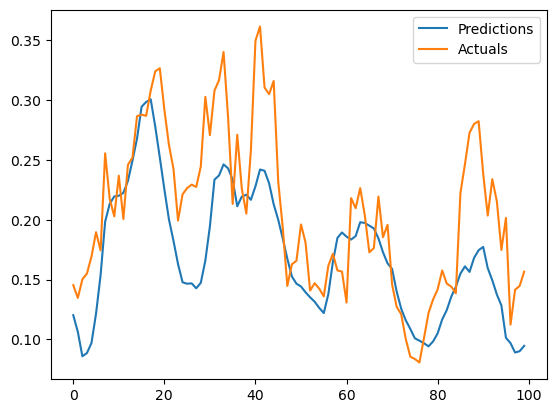

In [53]:
plot_predictions1(model4, X2_test, y2_test)

## Multiple targets - one time step

In [59]:
multi_df2 = multi_df.copy()

In [60]:

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = multi_df2.drop(columns=["PM10", "PM2,5", "NO2"])

y = multi_df2[["PM10", "PM2,5", "NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create a new DataFrame with the scaled features and target variable
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns, index=multi_df2.index)
y_scaled_df  = pd.DataFrame(data=y_scaled, columns=y.columns, index=multi_df2.index)
#df_scaled = y_scaled_df.merge(X_scaled_df, left_index=True, right_index=True)
#df_scaled
X_scaled_df


,east inbound,north inbound,south inbound,west inbound,east outbound,north outbound,south outbound,west outbound,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos,weekday
timestamp,,,,,,,,,,,,,,,,,,
2020-06-01 00:00:00,0.075855,0.106295,0.073346,0.207078,0.016736,0.120712,0.067273,0.331338,0.672131,0.639420,0.495833,0.049505,0.264624,0.500000,1.000000,0.752301,0.068324,0.000000
2020-06-01 01:00:00,0.043133,0.070741,0.046496,0.040663,0.008966,0.073411,0.042182,0.100142,0.688525,0.758075,0.446875,0.009901,0.309192,0.629410,0.982963,0.751992,0.068143,0.000000
2020-06-01 02:00:00,0.027764,0.038853,0.027177,0.018825,0.009564,0.030441,0.024727,0.059905,0.688525,0.907053,0.417708,0.019802,0.210306,0.750000,0.933013,0.751682,0.067963,0.000000
2020-06-01 03:00:00,0.019336,0.024100,0.014080,0.011295,0.001793,0.031261,0.015273,0.067057,0.688525,0.953197,0.397917,0.039604,0.196379,0.853553,0.853553,0.751372,0.067782,0.000000
2020-06-01 04:00:00,0.005949,0.033217,0.016372,0.008283,0.002391,0.022480,0.012000,0.101879,0.688525,0.979565,0.385417,0.009901,0.307799,0.933013,0.750000,0.751062,0.067602,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01 20:00:00,0.044621,0.412948,0.296005,0.443524,0.234907,0.441517,0.258909,0.308903,0.557377,0.222149,0.596875,0.356436,0.905292,0.066987,0.750000,0.749710,0.066820,0.333333
2022-06-01 21:00:00,0.037184,0.351462,0.213491,0.384036,0.157203,0.346447,0.207273,0.251774,0.581967,0.316414,0.550000,0.188119,0.930362,0.146447,0.853553,0.749399,0.066641,0.333333
2022-06-01 22:00:00,0.030739,0.259874,0.164702,0.292922,0.115959,0.239785,0.182182,0.207885,0.590164,0.465392,0.500000,0.079208,0.548747,0.250000,0.933013,0.749088,0.066462,0.333333


In [73]:
#create windows
def df_to_X_y2(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    n_steps_out = 3
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y 
    label = label = y_scaled[(i +window_size )]
   
    
    y.append(label)
  return np.array(X), np.array(y)

In [74]:
X5, y5 = df_to_X_y2(X_scaled_df)
X5.shape, y5.shape

((17531, 10, 18), (17531, 3))

In [75]:
#split data
X5_train, y5_train = X5[:10000], y5[:10000]
X5_val, y5_val = X5[10000:13500], y5[10000:13500]
X5_test, y5_test = X5[13500:], y5[13500:]
X5_train.shape, y5_train.shape, X5_val.shape, y5_val.shape, X5_test.shape, y5_test.shape


((10000, 10, 18),
 (10000, 3),
 (3500, 10, 18),
 (3500, 3),
 (4031, 10, 18),
 (4031, 3))

### Create model

In [76]:
#create model

# Clear the Keras session
clear_session()

# Set up checkpoint to save the best model
cp5 = ModelCheckpoint('model8/', save_best_only=True)

# Create the model
model5 = Sequential()

# Input layer
model5.add(InputLayer((10,18)))

model5.add(LSTM(512))
model5.add(Dropout(0.2))

# Decrease the number of neurons in Dense layers and add L1-Regularization
model5.add(Dense(164, activation='linear'))#, kernel_regularizer=l1(0.001)))
model5.add(Dense(24, activation='linear'))#, kernel_regularizer=l1(0.001)))


model5.add(Dense(3, activation='linear'))

#model5.compile(loss='mean_absolute_error', optimizer=Adagrad(learning_rate=1), metrics=[RootMeanSquaredError()])
model5.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_squared_error'])

# Display model summary
model5.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1087488   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 164)               84132     
                                                                 
 dense_1 (Dense)             (None, 24)                3960      
                                                                 
 dense_2 (Dense)             (None, 3)                 75        
                                                                 
Total params: 1,175,655
Trainable params: 1,175,655
Non-trainable params: 0
_________________________________________________________________


### Train model

In [77]:
#fit model
model5.fit(X5_train, y5_train, validation_data=(X5_val, y5_val), epochs=5, callbacks=[cp5])

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.0563 - mean_squared_error: 0.0089

313/313 [==============================] - 42s 121ms/step - loss: 0.0563 - mean_squared_error: 0.0089 - val_loss: 0.0472 - val_mean_squared_error: 0.0050
Epoch 2/5
313/313 [==============================] - 21s 66ms/step - loss: 0.0446 - mean_squared_error: 0.0050 - val_loss: 0.0524 - val_mean_squared_error: 0.0056
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.0431 - mean_squared_error: 0.0047

313/313 [==============================] - 36s 116ms/step - loss: 0.0431 - mean_squared_error: 0.0047 - val_loss: 0.0400 - val_mean_squared_error: 0.0037
Epoch 4/5
313/313 [==============================] - 23s 73ms/step - loss: 0.0413 - mean_squared_error: 0.0044 - val_loss: 0.0414 - val_mean_squared_error: 0.0042
Epoch 5/5
313/313 [==============================] - 23s 73ms/step - loss: 0.0399 - mean_squared_error: 0.0041 - val_loss: 0.0449 - val_mean_squared_error: 0.0047


### Predict and evaluate model

In [78]:
#load model
#model5 = load_model('model5/')
#model6 = load_model('model7/')
model6 = load_model('model8/')

In [79]:
#prediction for multiple target values

def plot_predictions2(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  pm10_preds, pm25_preds, no2_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2]
  pm10_actuals, pm25_actuals, no2_actuals = y[:, 0], y[:, 1], y[:, 2]
  df_pred = pd.DataFrame(data={'PM 10 Predictions': pm10_preds,
                          'PM 10 Actuals':pm10_actuals,
                          'PM 2,5 Predictions': pm25_preds,
                          'PM 2,5 Actuals': pm25_actuals,
                          'NO2 Predictions': no2_preds,
                          'NO2 Actuals': no2_actuals
                          })
  fig, axes = plt.subplots(2,2, figsize=(12, 8))

  #plot PM10 Predictions and Actuals
  axes[0, 0].plot(df_pred['PM 10 Predictions'][start:end], label='PM10 Predictions')
  axes[0, 0].plot(df_pred['PM 10 Actuals'][start:end], label='PM10 Actuals')
  axes[0, 0].legend()

  #plot PM2.5 Predictions and Actuals
  axes[0, 1].plot(df_pred['PM 2,5 Predictions'][start:end], label='PM2.5 Predictions')
  axes[0, 1].plot(df_pred['PM 2,5 Actuals'][start:end], label='PM2.5 Actuals')
  axes[0, 1].legend()

  #plot NO2 Predictions and Actuals
  axes[1, 0].plot(df_pred['NO2 Predictions'][start:end], label='NO2 Predictions')
  axes[1, 0].plot(df_pred['NO2 Actuals'][start:end], label='NO2 Actuals')
  axes[1, 0].legend()

  #remove the empty subplot
  fig.delaxes(axes[1, 1])

  plt.tight_layout()
  
  #plt.savefig('plot_predictions.png')
  plt.show()
  return show(df_pred[start:end])

In [80]:
model6.evaluate(X5_test, y5_test)

126/126 [==============================] - 3s 20ms/step - loss: 0.0485 - mean_squared_error: 0.0050


[0.04846566915512085, 0.005007978994399309]

126/126 [==============================] - 3s 20ms/step


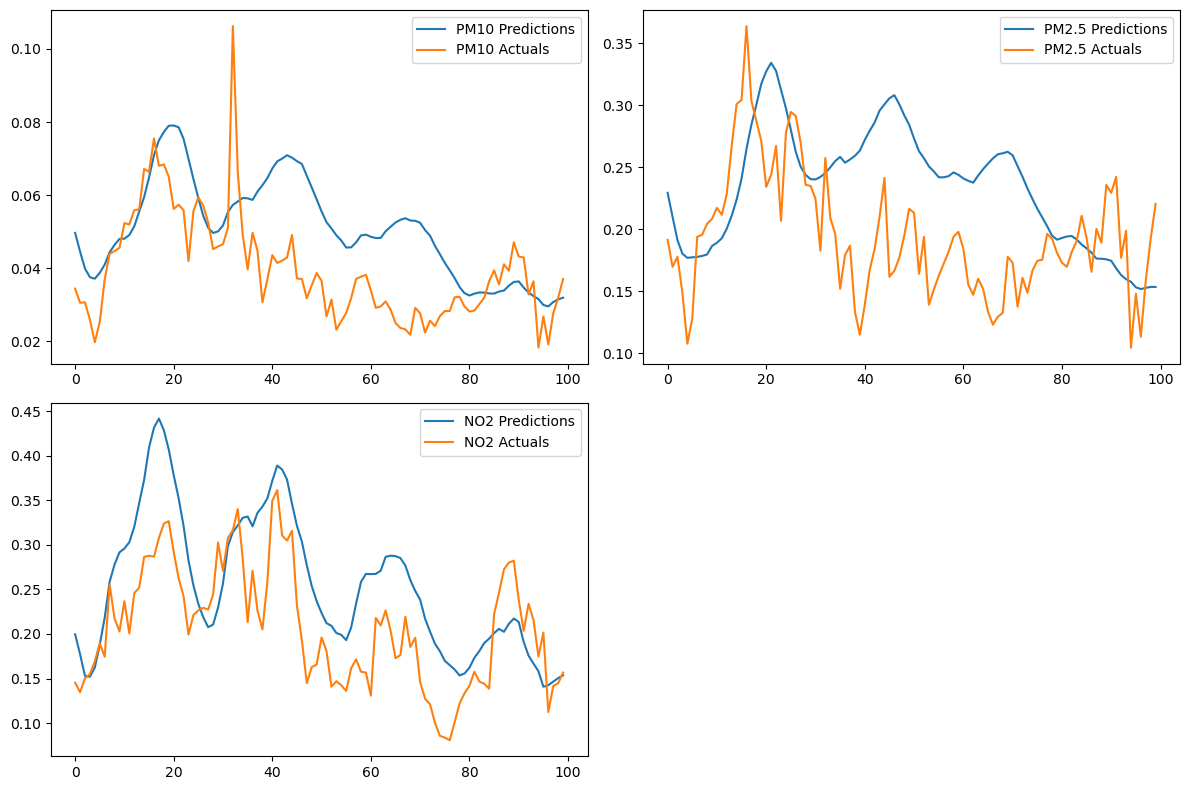

In [81]:
plot_predictions2(model6, X5_test, y5_test)

### Invert Prediction Values
Not working for multitarget predictions

In [ ]:
# Reshape 'Predictions' and 'Actuals' to have one feature
predictions = df['Predictions'].values.reshape(-1, 1)
actuals = df['Actuals'].values.reshape(-1, 1)


In [ ]:
predictions_inverted = scaler_y.inverse_transform(predictions)
actuals_inverted = scaler_y.inverse_transform(actuals)

In [ ]:
df_inverted = pd.DataFrame({
    'Predictions': predictions_inverted.flatten(),
    'Actuals': actuals_inverted.flatten()
})
df_inverted

In [ ]:
plt.plot(df_inverted['Predictions'])
plt.plot(df_inverted['Actuals'])
plt.title('Predictions for PM10')
plt.legend(['Predictions', 'Actuals'])
plt.savefig('predicts.png')


# Multivariate Time Series Forecasting (LSTM) for one target - Approach 2 

Based on https://www.kaggle.com/code/nicapotato/keras-timeseries-multi-step-multi-output

## One target - multiple time steps

### Standardize

In [111]:
multi_df_sc = multi_df.copy()

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Separate your DataFrame into features and target variable
X = multi_df_sc.drop(columns=["NO2"])

y = multi_df_sc[[ "NO2"]]

# Scale the features (X) and target (y) separately
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y).flatten()

# Create a new DataFrame with the scaled features and target variable
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns, index=multi_df_sc.index)
y_scaled_df  = pd.DataFrame(data=y_scaled, columns=y.columns, index=multi_df_sc.index)
#df_scaled = y_scaled_df.merge(X_scaled_df, left_index=True, right_index=True)
#df_scaled
X_scaled_df.shape, y_scaled.shape

((17541, 20), (17541,))

### Create tensors

In [112]:
# Data Loader Parameters

#number of training examples (data points) that are processed together in each forward and backward pass during one training iteration
BATCH_SIZE = 3

#how many elements from the dataset are loaded into a buffer at a time before shuffling
BUFFER_SIZE = 300

#data split
TRAIN_SPLIT = 12000
TEST_SPLIT = 15000

# Reproducibility
SEED = 45
tf.random.set_seed(SEED)

In [113]:
#creates train, val and test data

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [114]:
past_history = 20
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(X_scaled, y_scaled, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(X_scaled, y_scaled,
                                             TRAIN_SPLIT, TEST_SPLIT, past_history,
                                             future_target, STEP)
x_test_multi, y_test_multi = multivariate_data(X_scaled, y_scaled,
                                             TEST_SPLIT, None, past_history,
                                             future_target, STEP)


In [115]:
#checking shape of data
train_multi_shape = x_train_multi.shape, y_train_multi.shape
val_multi_shape = x_val_multi.shape, y_val_multi.shape
test_multi_shape = x_test_multi.shape, y_test_multi.shape

print("Training Data Shapes:", train_multi_shape)
print("Validation Data Shapes:", val_multi_shape)
print("Testing Data Shapes:", test_multi_shape)

Training Data Shapes: ((11980, 20, 20), (11980, 6))
Validation Data Shapes: ((2980, 20, 20), (2980, 6))
Testing Data Shapes: ((2515, 20, 20), (2515, 6))


In [116]:
#creates time series out of dataset
# #
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

test_data_multi = tf.data.Dataset.from_tensor_slices((x_test_multi, y_test_multi))
test_data_multi = test_data_multi.batch(BATCH_SIZE).repeat()

In [117]:
#have a look inside the tensors
for x, y in val_data_multi.take(1):  # Only take one batch
    print("x = ", x.numpy())
    print("y = ", y.numpy())


x =  [[[0.02528508 0.01703145 0.01473477 ... 0.0120425  0.60907558 0.5       ]
  [0.03420922 0.02779388 0.02455796 ... 0.01212081 0.60942531 0.5       ]
  [0.06346059 0.07486592 0.03110675 ... 0.01219937 0.60977498 0.5       ]
  ...
  [0.43777888 0.42382954 0.31597904 ... 0.01340781 0.61501324 0.5       ]
  [0.2830937  0.32642412 0.20235756 ... 0.01349037 0.61536199 0.5       ]
  [0.23004462 0.2335121  0.17845449 ... 0.01357319 0.61571068 0.5       ]]

 [[0.03420922 0.02779388 0.02455796 ... 0.01212081 0.60942531 0.5       ]
  [0.06346059 0.07486592 0.03110675 ... 0.01219937 0.60977498 0.5       ]
  [0.27813585 0.25565299 0.21480026 ... 0.01227818 0.6101246  0.5       ]
  ...
  [0.2830937  0.32642412 0.20235756 ... 0.01349037 0.61536199 0.5       ]
  [0.23004462 0.2335121  0.17845449 ... 0.01357319 0.61571068 0.5       ]
  [0.16559246 0.19299899 0.16895874 ... 0.01365625 0.61605931 0.5       ]]

 [[0.06346059 0.07486592 0.03110675 ... 0.01219937 0.60977498 0.5       ]
  [0.27813585 0.2

In [118]:

def create_time_steps(length):
    return list(range(-length, 0))

In [119]:

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

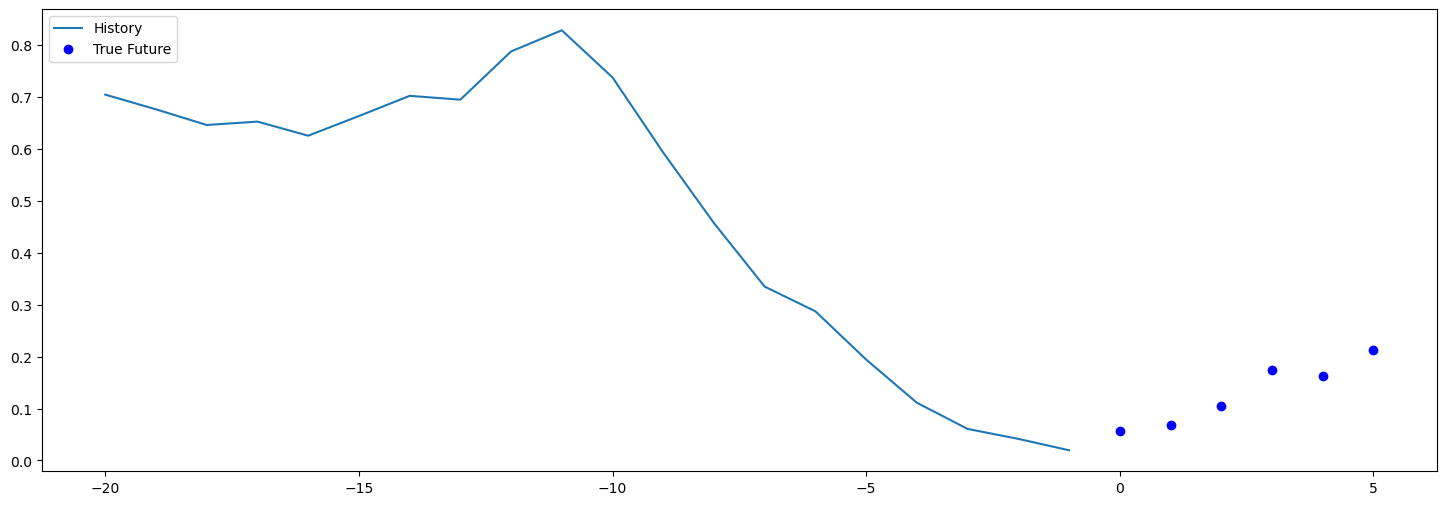

In [120]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))


### Create model

In [121]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128,
                                          #return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))

#multi_step_model.add(tf.keras.layers.LSTM(128, activation='linear'))
multi_step_model.add(Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(64, activation='linear'))
#multi_step_model.add(tf.keras.layers.Dense(64))
multi_step_model.add(tf.keras.layers.Dense(6))

multi_step_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae', metrics=['mean_squared_error'])
print(multi_step_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               76288     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 84,934
Trainable params: 84,934
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#GridSearchCV
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# Function to create model, required for KerasRegressor
def create_model(optimizer, activation, loss):
    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(512,
                                            return_sequences=True,
                                            input_shape=x_train_multi.shape[-2:]))

    multi_step_model.add(tf.keras.layers.LSTM(128, activation=activation))
    multi_step_model.add(Dropout(0.2))
    
    multi_step_model.add(tf.keras.layers.Dense(neurons)) #64
    multi_step_model.add(tf.keras.layers.Dense(6))

    multi_step_model.compile(optimizer=optimizer, loss=loss)
    
    return multi_step_model

# Define the grid search parameters
optimizer = ['SGD', 'RMSprop']#, 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
epochs = [10,50]
loss = ['mae', 'rmse']
activation  = ['softmax', 'softplus']#, 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
neurons = [16,32,64]


# Create a KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=1, epochs=epochs)

param_grid = dict(optimizer=optimizer, epochs = epochs, loss = loss, model__neurons=neurons, activation = activation, )

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose =1)

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

grid_result = grid.fit(x_train_multi, y_train_multi, callbacks=[early_stopping])

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [122]:
#check shape of prediction
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

1/1 [==============================] - 1s 1s/step
(3, 6)


In [130]:
#LSTM Parameters
EVALUATION_INTERVAL = 300
EPOCHS = 60
PATIENCE = 3

In [131]:
#checkpoints (choose one)

#early_stopping = EarlyStopping(monitor='mae', patience = PATIENCE, restore_best_weights=True)
#early_stopping = EarlyStopping(monitor='mean_absolute_error', patience = PATIENCE, restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)


### Train model

In [132]:
#train model
multi_step_history = multi_step_model.fit(train_data_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL, #only takes a specific number of batches to train per epoch
                                          validation_data=val_data_multi,
                                          validation_steps=EVALUATION_INTERVAL,
                                          callbacks=[reduce_lr]) # change if needed

Epoch 1/60
  1/300 [..............................] - ETA: 7s - loss: 0.0615 - mean_squared_error: 0.0056

300/300 [==============================] - 4s 14ms/step - loss: 0.0432 - mean_squared_error: 0.0040 - val_loss: 0.0415 - val_mean_squared_error: 0.0032 - lr: 5.0000e-04
Epoch 2/60
300/300 [==============================] - 4s 13ms/step - loss: 0.0504 - mean_squared_error: 0.0049 - val_loss: 0.0434 - val_mean_squared_error: 0.0037 - lr: 5.0000e-04
Epoch 3/60
300/300 [==============================] - 4s 13ms/step - loss: 0.0583 - mean_squared_error: 0.0080 - val_loss: 0.0408 - val_mean_squared_error: 0.0032 - lr: 5.0000e-04
Epoch 4/60
300/300 [==============================] - 4s 12ms/step - loss: 0.0434 - mean_squared_error: 0.0039 - val_loss: 0.0436 - val_mean_squared_error: 0.0037 - lr: 5.0000e-04
Epoch 5/60
300/300 [==============================] - 4s 13ms/step - loss: 0.0418 - mean_squared_error: 0.0030 - val_loss: 0.0443 - val_mean_squared_error: 0.0032 - lr: 5.0000e-04
Epoch 6/60
300/300 [==============================] - 4s 13ms/step - loss: 0.0401 - mean_squared_error: 0.0027 

In [133]:
#save model
multi_step_model.save('6h3.h5')

### Predict and evaluate model

In [138]:
# function to plot predictions, history and actuals with inverted values
def multi_step_plot_invert(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.savefig('predictions_6h.png')
    plt.show()

1/1 [==============================] - 0s 71ms/step


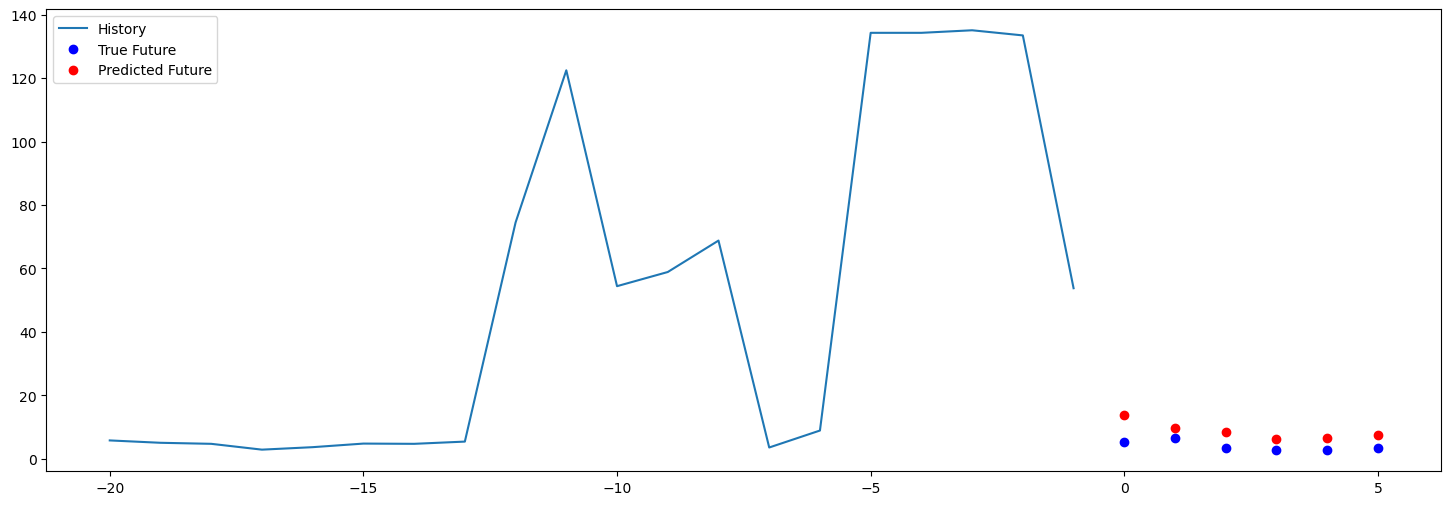

[0.0261672493070364, 0.0007862793281674385]


In [140]:
#plot predictions, history and actuals with inverted values on test data
for x, y in test_data_multi.take(1):
    predictions = multi_step_model.predict(x)
    
    
    # Invert the scaling on predictions
    predictions_inverted = scaler_y.inverse_transform(predictions)
    predictions_inverted = predictions_inverted[0].flatten()
    y_inverted = scaler_y.inverse_transform(y.numpy())
    x_inverted = scaler_y.inverse_transform(x[0].numpy())
    
    
    multi_step_plot_invert(x_inverted[0], y_inverted[0], predictions_inverted)
    
    loss = multi_step_model.evaluate(x, y, verbose=0)
    print(loss)


1/1 [==============================] - 0s 27ms/step


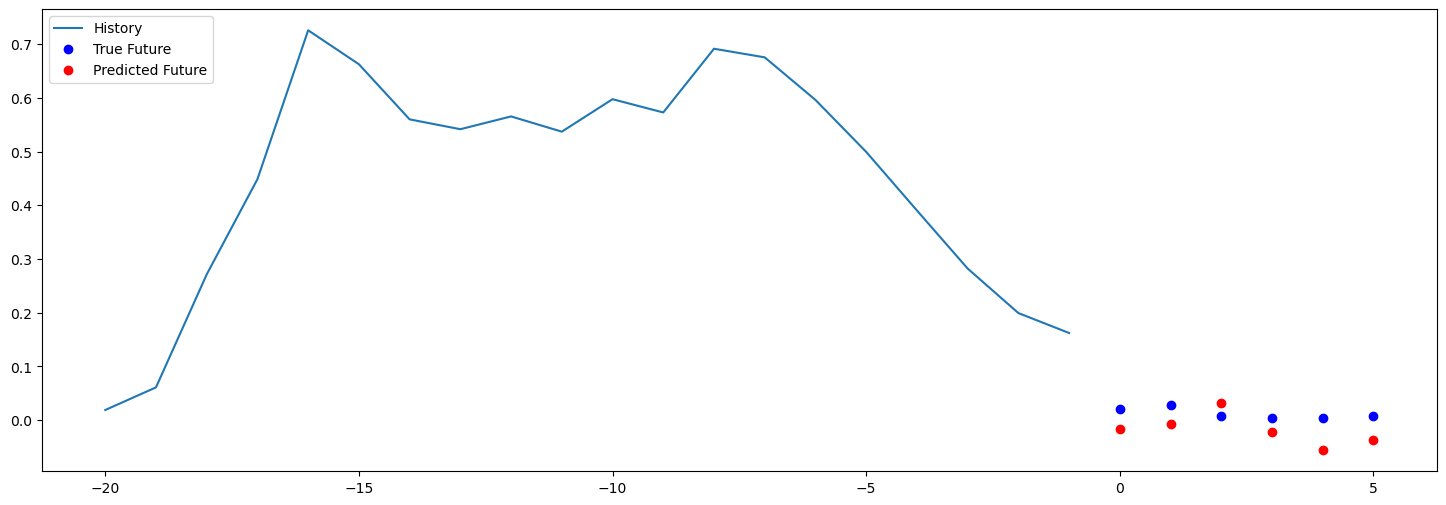

1/1 [==============================] - 0s 33ms/step


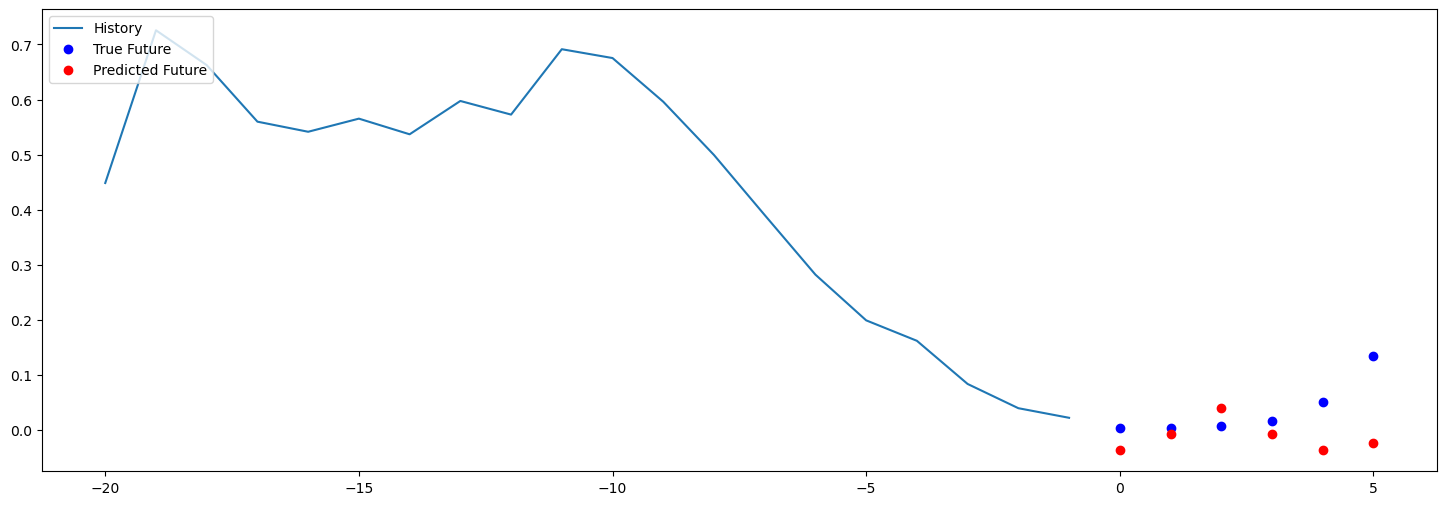

In [229]:
#plot predictions, history and actuals with scaled values on test data
for x, y in test_data_multi.take(2):
       multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [485]:
#clear variables
del multi_step_model, val_data_multi, train_data_multi
_ = gc.collect()

